# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from fancyimpute import KNN, SoftImpute
from imblearn.over_sampling import SMOTE
import joblib
import operator

%matplotlib inline


## Defining system variables

In [2]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [3]:
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [4]:
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

# Defining Useful Functions

In [5]:

def classify(est, x, y,X_test,y_test):
    # Passing the model and train test dataset to fit the model
    est.fit(x, y)
    # Predicting the probabilities of the Tet data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    # Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))
    
    return est, y1, y2[:, 1]


# Function to find which features are more important than others through model
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(df_LC.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key = operator.itemgetter(1), reverse = True)
    
    return sorted_x

# Model to predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth = 6, n_estimators = 100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators = 10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model_type','model','roc_auc_score', 'matthews_corrcoef', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        # models_report = models_report.append(tmp, ignore_index = True)
        models_report.loc[len(models_report)] = tmp
        # models_report = pd.concat([models_report, tmp], axis=0, ignore_index=True)  # Concatenate the DataFrame with the Series
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop = {'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

# Reading Data from CSV

In [6]:
data = pd.read_csv("LoansTrainingSet.csv", low_memory=False)

In [7]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [8]:
len(data)

111107

In [9]:
# Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset = "Loan ID",keep = 'first',inplace = True)

## Analyzing Outcome Variable: Loan Status

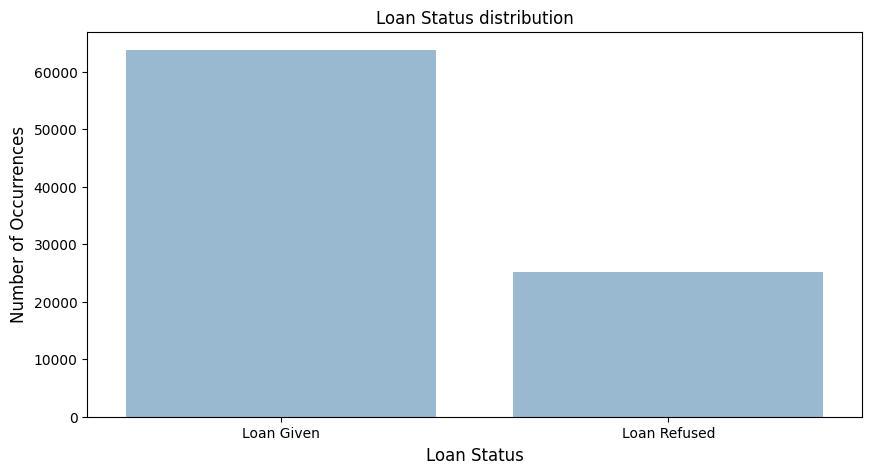

In [10]:
# PLotting the loan status 
status = data["Loan Status"].value_counts() 

plt.figure(figsize = (10,5))
sns.barplot(x = status.index, y = status.values, alpha = 0.5)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Loan Status', fontsize = 12)
plt.show()

## Analyzing Current Loan Amount

In [11]:
# Current Loan Amount #
data["Current Loan Amount"].describe()


count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

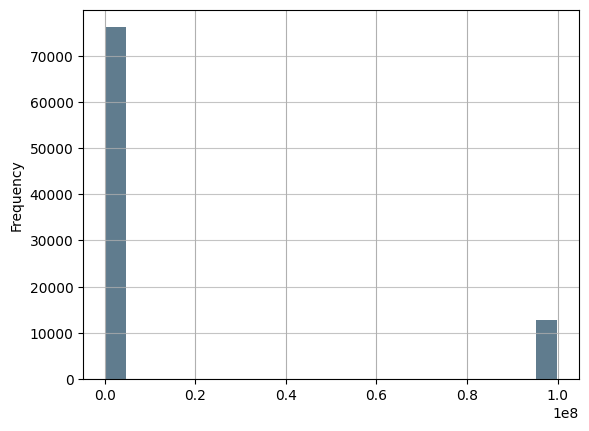

In [12]:
# Current Loan Amount #
data["Current Loan Amount"].plot.hist(grid = True, bins = 20, rwidth = 0.9,
                                      color ='#607c8e')
plt.grid(axis = 'y', alpha = 0.75)

In [13]:
# Finding IQR's for outlier removal
Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [14]:
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]

5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [15]:
temp = np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, np.nan, temp)


count         76172.0
mean     13933.915756
std       8235.921922
min             491.0
25%            7810.0
50%           12038.0
75%           19351.0
max           35875.0
Name: Current Loan Amount_temp, dtype: Float64

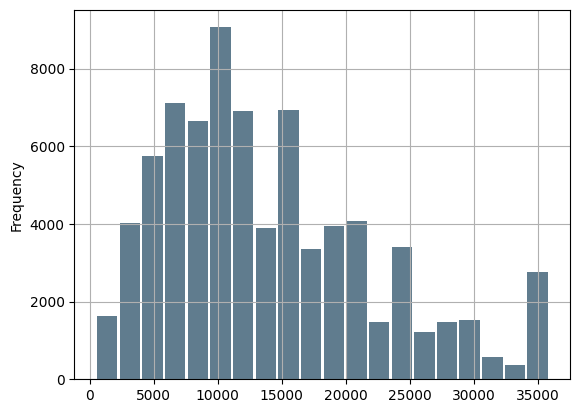

In [16]:
# Remove NaN values and replace infinite values with NaN
temp = data["Current Loan Amount_temp"].dropna().replace([np.inf, -np.inf], np.nan)

# Convert values to integers
temp = temp.astype(float).astype('Int64')

# Plot histogram
temp.plot.hist(grid = True, bins = 20, rwidth = 0.9, color = '#607c8e')

# Display summary statistics
temp.describe()

In [17]:
# Replace values greater than 9999998 with either the 50th percentile or the mean
temp = np.array(data["Current Loan Amount"].values.tolist())
replacement_value = np.percentile(temp, 50)  # 50th percentile value

# Or you can use mean value:
# replacement_value = np.mean(temp)
data["Current Loan Amount"] = np.where(temp > 9999998, replacement_value, temp).tolist()

# Drop the temporary column if it exists
data = data.drop(['Current Loan Amount_temp'], axis=1)

## Analyzing Loan Term

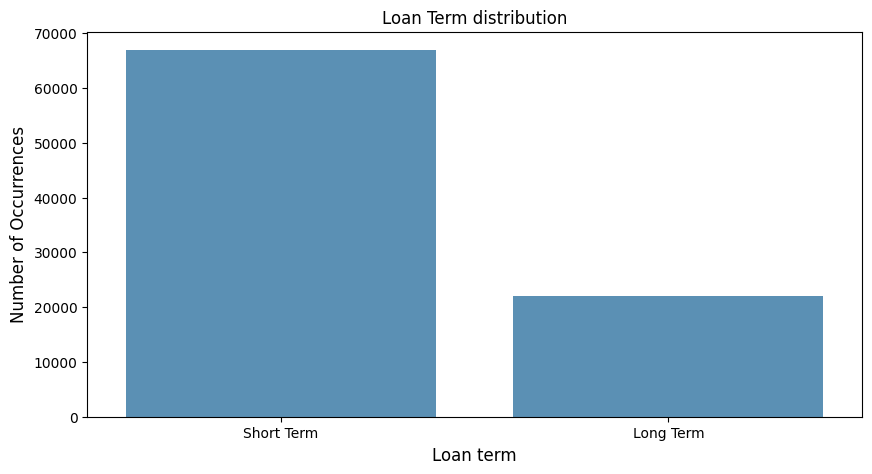

In [18]:
# Loan Term #
status = data["Term"].value_counts() 

plt.figure(figsize = (10,5))
sns.barplot(x = status.index, y = status.values, alpha = 0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Loan term', fontsize = 12)
plt.show()


## Analyzing Credit Score

In [19]:
# Credit Score #

data["Credit Score"].describe()

count    67572.000000
mean      1199.199580
std       1680.813805
min        585.000000
25%        714.000000
50%        733.000000
75%        744.000000
max       7510.000000
Name: Credit Score, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f62cfca6970>,
 'caps': [<matplotlib.lines.Line2D at 0x7f62cfca6eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f62cfca66d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f62cfcb6430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f62cfcb66d0>],
 'means': []}

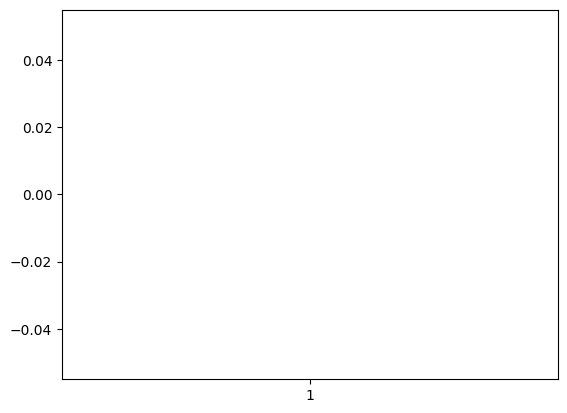

In [20]:
# Max is 7510. It should be between 0-800
plt.boxplot(data["Credit Score"])

In [21]:
data["Credit Score"].isnull().sum()


21338

In [22]:
# Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10

data["Credit Score"] = np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])


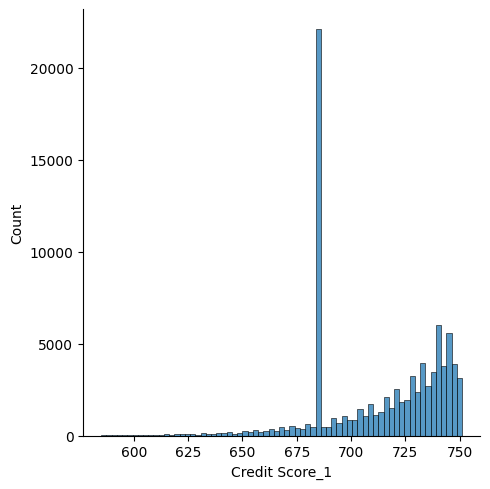

In [23]:
# Now lets replace the missing values with median 
# Calculate the median score
median_score = statistics.median(data["Credit Score"])

# Create a copy of "Credit Score" column as "Credit Score_1" and fill missing values with the median
data["Credit Score_1"] = data["Credit Score"].fillna(median_score)

# Create a density plot for the "Credit Score_1" column
sns.displot(data["Credit Score_1"])


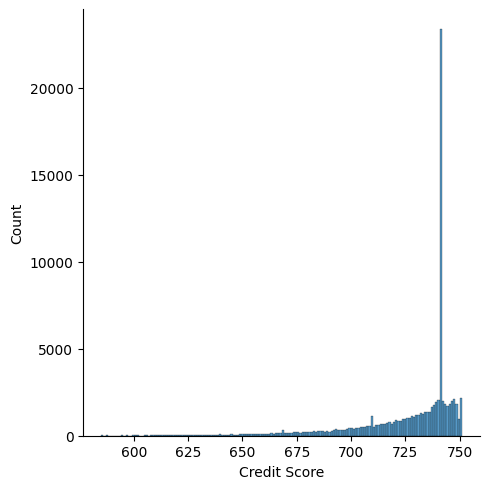

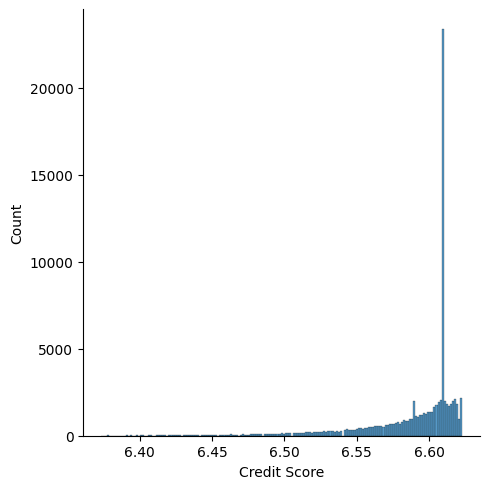

In [24]:
# As we can see this data is skewed so when we replace it with median it is giving us problems. 
# Replacing with 75th percentile and taking log we get a better distribution

# Fill missing values with 741
data["Credit Score"].fillna(741, inplace=True) # credit score 741 is good!

# Create density plot for the original data
sns.displot(data["Credit Score"])

# Create density plot for the log-transformed data
sns.displot(np.log(data["Credit Score"] + 1))  # Adding 1 to avoid log(0)

## Analyzing Home Ownership

In [25]:
data['Home Ownership'].unique()

array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

## Analyzing Annual Income

In [26]:
# Annual Income #
data['Annual Income'].describe()


count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [27]:
# Lets look at the quantiles of this column

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [28]:
# As we can see they lie in the 99th percentile of the data. Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287

data['Annual Income'].isna().sum()

# So we have about 21000 null values 
# We will impute the mising data with other columns towards the end


21338

## Analyzing Loan Purpose

In [29]:
# Loan Purpose #
data['Purpose'].value_counts()

Purpose
Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: count, dtype: int64

## Analyzing Monthly Debt

In [30]:
# Monthly debt #
data['Monthly Debt'].describe()

# So this is not numeric column. Lets explore

count     88910
unique    70066
top           0
freq         69
Name: Monthly Debt, dtype: object

In [31]:
# pd.to_numeric(data['Monthly Debt'] )
# As we can see there is a $ symbol present. Lets replace it 


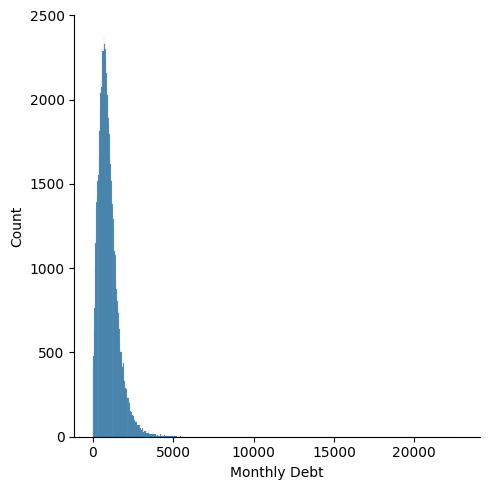

In [32]:
# Replace '$' symbol with an empty string and convert to numeric
data['Monthly Debt'] = pd.to_numeric(data['Monthly Debt'].str.replace('$', ''))

sns.displot(data["Monthly Debt"])


In [33]:
data['Monthly Debt'].describe()
# The max value is too high here


count    88910.000000
mean       963.102059
std        637.524064
min          0.000000
25%        532.220000
50%        843.925000
75%       1250.527500
max      22939.120000
Name: Monthly Debt, dtype: float64

In [34]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     463.75000
0.750    1250.52750
0.900    1743.08300
0.950    2115.51100
0.990    3087.11100
0.999    4926.37475
Name: Monthly Debt, dtype: float64

In [35]:
# Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
# So problem again is wit 99th percentile


0.9995    5482.111455
0.9999    7774.610660
Name: Monthly Debt, dtype: float64

In [36]:
data['Monthly Debt'].quantile([0.9997,.99999])
# 0.99970     5978.574911
# 0.99999    13262.762330


0.99970     5978.574911
0.99999    13262.762330
Name: Monthly Debt, dtype: float64

In [37]:
data['Monthly Debt'].quantile([0.999,1])


0.999     4926.37475
1.000    22939.12000
Name: Monthly Debt, dtype: float64

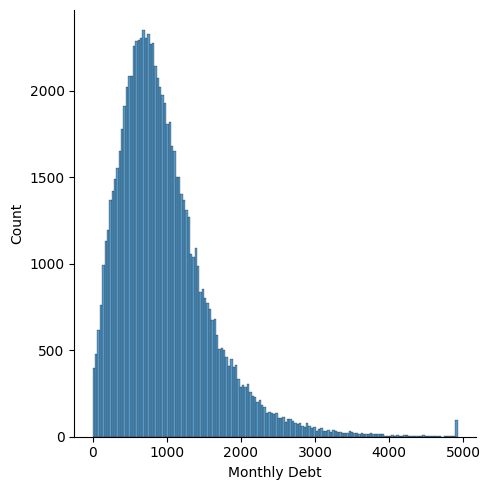

In [38]:
# Need to replace this
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.displot(data["Monthly Debt"])
# Now we get the right distribution


## Analyzing Years of Credit History

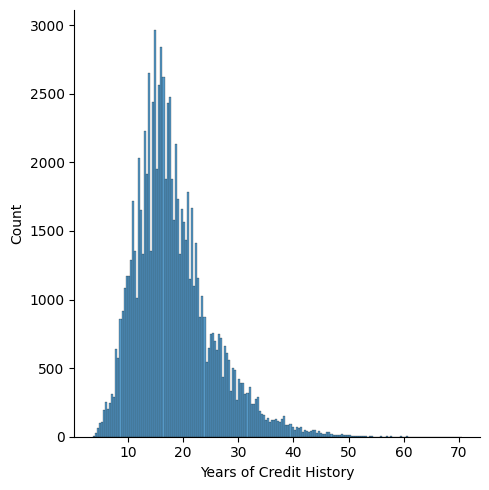

In [39]:
# Years of credit history #

data['Years of Credit History'].value_counts()

sns.displot(data["Years of Credit History"])
# Over all looks pretty clean! no need of doing anything


## Analyzing the Months since last delinquent 

In [40]:
# Months since last delinquent #
data['Months since last delinquent'].describe()


count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [41]:
# Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()

# We have nearly 48506 NA's. We will try to handle them later

48506

## Analyzing the number of Open Accounts

In [42]:
# Number of open accounts #
data['Number of Open Accounts'].describe()

# The max number seems odd. Lets investigate

count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

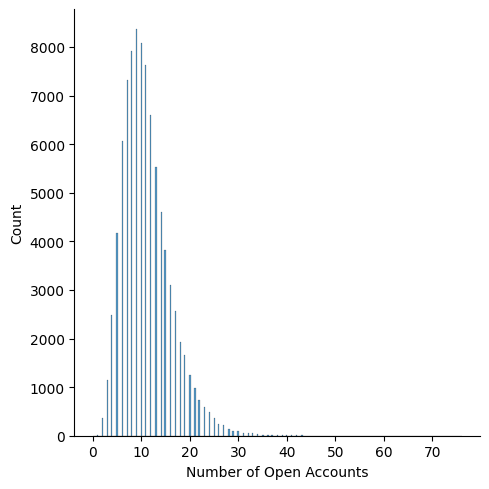

In [43]:
sns.displot(data['Number of Open Accounts'])
# Yes there are outliers in this columns. Let dig deeper


In [44]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
# Ok so replacing anything greater than 99th percentile with 99th percentile values


0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

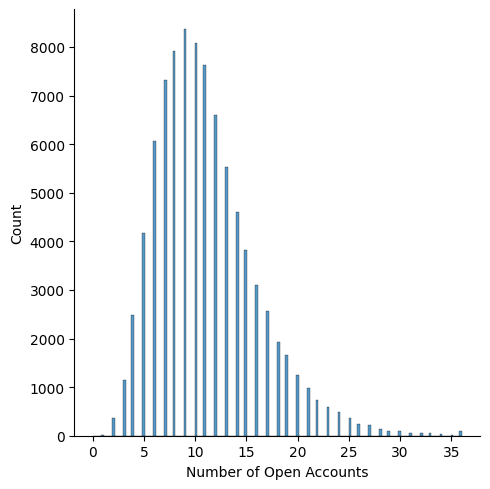

In [45]:
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36

sns.displot(data['Number of Open Accounts'])
# Looks good now


## Analyzing Number of Credit Problems

In [46]:
# Number of Credit problems #
data['Number of Credit Problems'].describe() 
# Max looks a bit higher. Lets see

count    88910.000000
mean         0.160477
std          0.473746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64

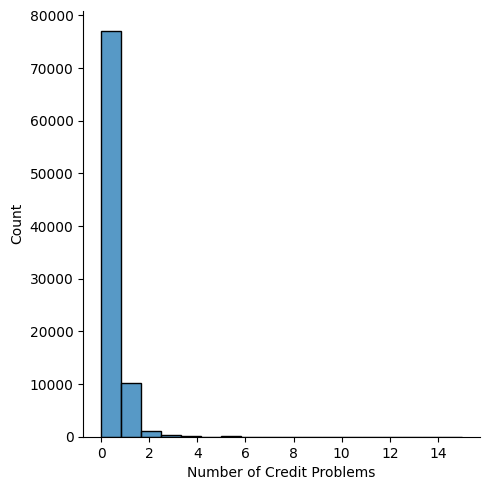

In [47]:

sns.displot(data['Number of Credit Problems'])

In [48]:
# lets look at value _counts
data['Number of Credit Problems'].value_counts()

# Okay looks good


Number of Credit Problems
0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: count, dtype: int64

## Analyzing Current Credit Balance

In [49]:
# Current Credit Balance #
data['Current Credit Balance'].describe()

count    8.891000e+04
mean     1.543593e+04
std      1.965873e+04
min      0.000000e+00
25%      5.949000e+03
50%      1.103900e+04
75%      1.930100e+04
max      1.730472e+06
Name: Current Credit Balance, dtype: float64

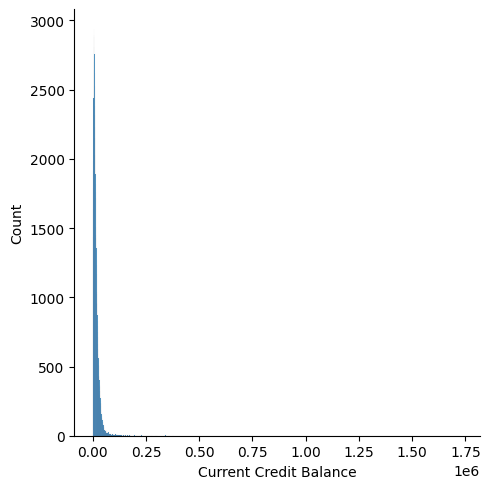

In [50]:
sns.displot(data['Current Credit Balance'])
# It seems there are outliers in this data. Lets investigate


In [51]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])


0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [52]:
#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

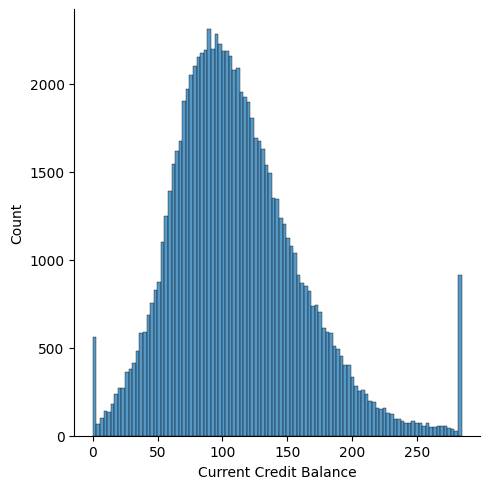

In [53]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007

sns.displot(data['Current Credit Balance']**(1/2))
# The plot doesnt look good. We need to transform it


In [54]:
data['Current Credit Balance'] = data['Current Credit Balance']**(1/2)


## Analyzing Max Open Credit 

In [55]:
# Max Open credit #
data['Maximum Open Credit'].describe()


count     88910
unique    46625
top           0
freq        610
Name: Maximum Open Credit, dtype: object

In [56]:
data['Maximum Open Credit'].value_counts()


Maximum Open Credit
0        610
10782     10
14382     10
17464     10
11044     10
        ... 
46635      1
25110      1
54780      1
42402      1
53374      1
Name: count, Length: 46625, dtype: int64

In [57]:
# sns.distplot(data['Maximum Open Credit'])
# So there are some str characters present in the data. Lets find them
# could not convert string to float: '#VALUE!'


In [58]:
# pd.to_numeric(data['Maximum Open Credit'])
# Unable to parse string "#VALUE!" at position 4930

In [59]:

data['Maximum Open Credit'] = pd.to_numeric(data['Maximum Open Credit'], errors='coerce')


In [60]:
data['Maximum Open Credit'].isnull().sum()
# Now we have only 2 NaNs in the data. Lets replace them with mean  


2

In [61]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])

0.55       24036.85
0.76       37260.00
0.87       50737.00
0.98      114682.88
0.99      171423.93
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [62]:
data['Maximum Open Credit'] = data['Maximum Open Credit'].fillna(35965)


In [63]:
# Lets replace the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423


## Analyzing Bancruptcies

In [64]:
# Bankruptcies #
data['Bankruptcies'].describe()


count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [65]:
data['Bankruptcies'].value_counts()


Bankruptcies
0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: count, dtype: int64

In [66]:
data['Bankruptcies'].unique()

# So we have NaN's. Lets fill them with median


array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [67]:
data['Bankruptcies'] = data['Bankruptcies'].fillna(3)


## Analyzing Tax Liens

In [68]:
# Tax Liens #
data['Tax Liens'].describe()


count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [69]:
data['Tax Liens'].value_counts()

Tax Liens
0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: count, dtype: int64

# Modelling

## Hadling Categorical Columns

In [70]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

## Imputing Missing Data and Dropping Unnecessary Variables

In [71]:
# Imputing missing data with soft impute
updated_data = pd.DataFrame(data = SoftImpute().fit_transform(data[data.columns[3:19]],), columns = data[data.columns[3:19]].columns, index = data.index)
# Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23109948.338522
[SoftImpute] Iter 1: observed MAE=260.775875 rank=3
[SoftImpute] Iter 2: observed MAE=260.733346 rank=3
[SoftImpute] Iter 3: observed MAE=260.740490 rank=3
[SoftImpute] Iter 4: observed MAE=260.760389 rank=3
[SoftImpute] Iter 5: observed MAE=260.783025 rank=3
[SoftImpute] Iter 6: observed MAE=260.805662 rank=3
[SoftImpute] Iter 7: observed MAE=260.827347 rank=3
[SoftImpute] Iter 8: observed MAE=260.847777 rank=3
[SoftImpute] Iter 9: observed MAE=260.866844 rank=3
[SoftImpute] Iter 10: observed MAE=260.884690 rank=3
[SoftImpute] Iter 11: observed MAE=260.901240 rank=3
[SoftImpute] Iter 12: observed MAE=260.916512 rank=3
[SoftImpute] Iter 13: observed MAE=260.930579 rank=3
[SoftImpute] Iter 14: observed MAE=260.943633 rank=3
[SoftImpute] Iter 15: observed MAE=260.955568 rank=3
[SoftImpute] Iter 16: observed MAE=260.966499 rank=3
[SoftImpute] Iter 17: observed MAE=260.976354 rank=3
[SoftImpute] Iter 18: observed MAE=260.985328 ra

## Handling Target Variable and Preprocessing Factors

In [72]:
data['Loan Status'] = data['Loan Status'].fillna('Loan Refused')

In [73]:
data['Loan Status'].unique()

array(['Loan Refused', 'Loan Given'], dtype=object)

In [74]:
# Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y = lb_results
y = y.ravel()

# Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)


[[-0.23112821 -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958407]
 [ 1.44530309  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958407]
 [ 0.27841142 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958407]
 ...
 [ 1.36398659 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958407]
 [-1.17571107 -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958407]
 [ 0.58387289 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361202]]
   
(88910, 16)


In [75]:
# Looking at other models using different classifiers #
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 22)

Accuracy:  0.726389982379185
Area under the ROC curve:  0.7394947633951932
F-metric:  0.38537982145864913
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     18981
           1       0.55      0.30      0.39      7692

    accuracy                           0.73     26673
   macro avg       0.65      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:
[0.73007712 0.73417416 0.7337511  0.73262634 0.72812726]
[0.16703874 0.23084939 0.14140712 0.0311692  0.04476034 0.04969415
 0.03414987 0.03290632 0.03169009 0.03070426 0.03009326 0.02951543
 0.03393674 0.03623368 0.03347385 0.04237754]


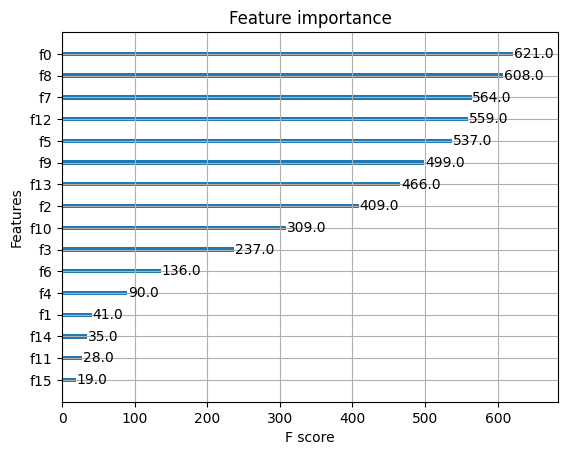

In [76]:
# Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)


In [77]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

Accuracy:  0.7120683837588573
Area under the ROC curve:  0.7394312196806928
F-metric:  0.004665629860031105
 
Classification report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     18981
           1       0.75      0.00      0.00      7692

    accuracy                           0.71     26673
   macro avg       0.73      0.50      0.42     26673
weighted avg       0.72      0.71      0.59     26673

 
Evaluation by cross-validation:
[0.71955334 0.71923201 0.71920945 0.71969149 0.71904877]


In [78]:
# K nearest Neighbour classifier #
knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)


Accuracy:  0.6820005248753421
Area under the ROC curve:  0.6070197691738869
F-metric:  0.3161883263463399
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.79     18981
           1       0.42      0.25      0.32      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.56      0.55     26673
weighted avg       0.65      0.68      0.66     26673

 
Evaluation by cross-validation:
[0.69199871 0.69296272 0.69583032 0.68956375 0.68940307]


In [79]:
# Logistic Regression #
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Accuracy:  0.7191916919731564
Area under the ROC curve:  0.6697803394987072
F-metric:  0.20639966094511547
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.64      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72405206 0.7276671  0.72668113 0.72708283 0.72411023]


In [80]:
# Decision Tree Classifier # 
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6482210475012185
Area under the ROC curve:  0.5779704801278822
F-metric:  0.4031550155842503
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     18981
           1       0.39      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.65      0.65      0.65     26673

 
Evaluation by cross-validation:
[0.65898136 0.66163239 0.65895396 0.6586326  0.65180365]


computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 
computing XGBClassifier - Non-balanced 


,model_type,model,roc_auc_score,matthews_corrcoef,precision_score,recall_score,f1_score
0,Non-balanced,GradientBoosting,0.751445,0.243853,0.583617,0.24683,0.346931
1,Non-balanced,LogisticRegression,0.673092,0.151175,0.556522,0.117139,0.193541
2,Non-balanced,RandomForestClassifier,0.695369,0.186664,0.504743,0.229572,0.3156
3,Non-balanced,XGBClassifier,0.741868,0.240836,0.540802,0.292849,0.379951


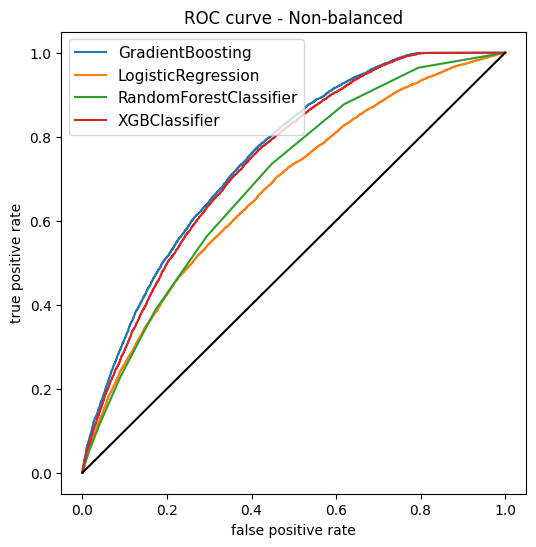

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
models_report

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 
computing XGBClassifier - Balanced 


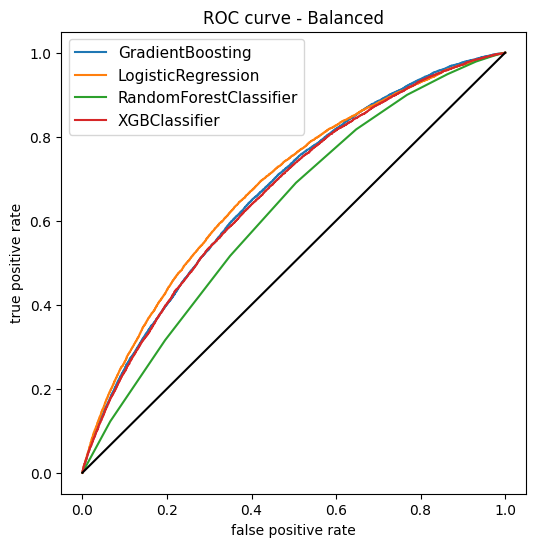

In [82]:
# Synthetically balancing the dataset # 
index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [83]:
# GBM Model #
# save model
gbm = GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model.pkl')
# load model
# gbm_pickle = joblib.load('GBM_Model.pkl')

['GBM_Model.pkl']